In [2]:
import pyspark
from os import listdir
from os.path import isfile, join
import boto3
import pandas as pd
from sagemaker import get_execution_role
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType

# Set up environement

In [3]:
conf = pyspark.SparkConf().setAppName('odl').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
sqlc = pyspark.sql.SQLContext(sc)
sc

<SparkContext master=local appName=odl>

# EDA

In [5]:
data_location = 'admission.csv'
pddf = pd.read_csv(data_location)

In [6]:
pddf = pddf.dropna()
df = sqlc.createDataFrame(pddf)

In [7]:
display(df)

DataFrame[Serial No.: bigint, GRE Score: bigint, TOEFL Score: bigint, University Rating: bigint, SOP: double, LOR : double, CGPA: double, Research: bigint, Chance of Admit : double]

In [8]:
df.printSchema()

root
 |-- Serial No.: long (nullable = true)
 |-- GRE Score: long (nullable = true)
 |-- TOEFL Score: long (nullable = true)
 |-- University Rating: long (nullable = true)
 |-- SOP: double (nullable = true)
 |-- LOR : double (nullable = true)
 |-- CGPA: double (nullable = true)
 |-- Research: long (nullable = true)
 |-- Chance of Admit : double (nullable = true)



In [9]:
df.show(10)

+----------+---------+-----------+-----------------+---+----+----+--------+----------------+
|Serial No.|GRE Score|TOEFL Score|University Rating|SOP|LOR |CGPA|Research|Chance of Admit |
+----------+---------+-----------+-----------------+---+----+----+--------+----------------+
|         1|      337|        118|                4|4.5| 4.5|9.65|       1|            0.92|
|         2|      324|        107|                4|4.0| 4.5|8.87|       1|            0.76|
|         3|      316|        104|                3|3.0| 3.5| 8.0|       1|            0.72|
|         4|      322|        110|                3|3.5| 2.5|8.67|       1|             0.8|
|         5|      314|        103|                2|2.0| 3.0|8.21|       0|            0.65|
|         6|      330|        115|                5|4.5| 3.0|9.34|       1|             0.9|
|         7|      321|        109|                3|3.0| 4.0| 8.2|       1|            0.75|
|         8|      308|        101|                2|3.0| 4.0| 7.9|    

In [10]:
print("Pearson's r(GRE,TOEFL) = {}".format(df.corr("GRE Score", "TOEFL Score")))
print("Pearson's r(GRE,Univ_Rating) = {}".format(df.corr("GRE Score", "University Rating")))
print("Pearson's r(SOP,LOR) = {}".format(df.corr("SOP", "LOR ")))

Pearson's r(GRE,TOEFL) = 0.8272004035317205
Pearson's r(GRE,Univ_Rating) = 0.6353762113238999
Pearson's r(SOP,LOR) = 0.6637068525149349


# Vectorization

In [14]:
df = df.select('GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ',  'CGPA',\
               'Research', 'Chance of Admit ')

In [26]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint

transformed_df = df.rdd.map(lambda row: LabeledPoint(row[-1], Vectors.dense(row[0:-1])))


In [27]:
(testDF, trainDF) = transformed_df.randomSplit((0.20, 0.80))
print ('training set N = {}, test set N = {}'.format(trainingDF.count(),testDF.count()))

training set N = 393, test set N = 110


# Train the model

In [25]:
from pyspark.mllib.tree import RandomForest, RandomForestModel

In [36]:
def train_rf(numTrees=3):
    model = RandomForest.trainRegressor(trainDF, categoricalFeaturesInfo={},
                                        numTrees=numTrees, featureSubsetStrategy="auto",
                                        impurity='variance', maxDepth=4, maxBins=32)

    # Evaluate model on test instances and compute test error
    predictions = model.predict(testDF.map(lambda x: x.features))
    labelsAndPredictions = testDF.map(lambda lp: lp.label).zip(predictions)
    testMSE = labelsAndPredictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
        float(testDF.count())
    return str(testMSE)
    #print('Learned regression forest model:')
    #print(model.toDebugString())

In [46]:
y=[]

for i in range(3,7):
    y.append(round(float(train_rf(i)),8)*100)



<BarContainer object of 4 artists>

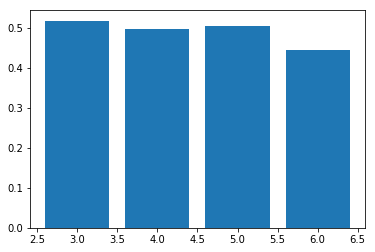

In [47]:
import matplotlib.pyplot as plt


plt.bar([3,4,5,6],y, align='center')